# Illustrations of SoftwareX 2019 article 

This notebook repoduces the illustrations of the jounral article presenting Higra:

>B. Perret, G. Chierchia, J. Cousty, S.J. F. Guimarães, Y. Kenmochi, L. Najman,
>[Higra: Hierarchical Graph Analysis](http://www.sciencedirect.com/science/article/pii/S235271101930247X) ,
>SoftwareX, Volume 10, 2019. DOI: [10.1016/j.softx.2019.100335](https://doi.org/10.1016/j.softx.2019.100335)
    
    

In [1]:
%%capture
!pip install higra

In [2]:
import numpy as np
import higra as hg
import imageio
import sklearn.datasets
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

try:
    from utils import * # locate_resource
except: # we are probably running from the cloud, try to fetch utils functions from URL
    import urllib.request as request; exec(request.urlopen('https://github.com/higra/Higra-Notebooks/raw/master/utils.py').read(), globals())

# Hierarchical clustering simplification

This example demonstrates the construction of a single-linkage hierarchical clustering and its simplification by a cluster size criterion. One classical issue with the single-linkage clustering is the presence of very small clusters branching very high in the hierarchy. Such clusters are non-relevant and can be sent back to the very bottom of the hierarchy. In the example, a hierarchy is constructed from a graph made of 3 clusters. One can see that, in Higra, a hierarchy is indeed a tuple of 2 elements: a tree and an array which associates an altitude with each node of the tree (also called tree distance in the literature). A flat clustering into three classes is extracted from the hierarchy. The hierarchy is then simplified: all clusters whose size is smaller than 7 elements are removed. Finally, the dendrogram of the simplified hierarchy is computed and the new 3 class clustering is extracted. We can see that the simplified hierarchy does not contain any small cluster anymore and the corresponding flat clustering into 3 classes is greatly improved.

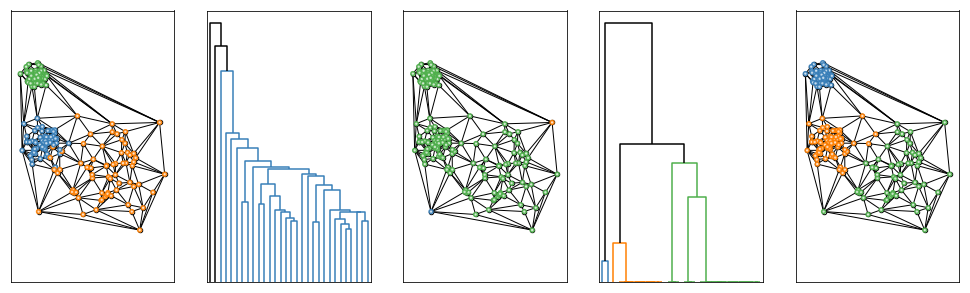

In [12]:
plt.figure(figsize=(5 * 3 + 2, 5))
# create a graph from a random 2d point cloud
X, labels = sklearn.datasets.make_blobs(200, cluster_std=[1.0, 2.5, 0.5], random_state=220)
graph, edge_weights = hg.make_graph_from_points(X, 'delaunay')
plt.subplot(1,5,1); hg.plot_graph(graph, vertex_positions=X, vertex_labels=labels)

# single-linkage clustering
tree, altitudes = hg.binary_partition_tree_single_linkage(graph, edge_weights)
plt.subplot(1,5,2); hg.plot_partition_tree(tree, altitudes=altitudes, n_clusters=3)

# flat clustering
pred = hg.labelisation_horizontal_cut_from_num_regions(tree, altitudes, 3)
plt.subplot(1,5,3); hg.plot_graph(graph, vertex_positions=X, vertex_labels=pred)

# hierarchy simplification
tree, altitudes = hg.filter_small_nodes_from_tree(tree, altitudes, 7)
plt.subplot(1,5,4); hg.plot_partition_tree(tree, altitudes=altitudes, n_clusters=3)

# flat clustering
pred = hg.labelisation_horizontal_cut_from_num_regions(tree, altitudes, 3)
plt.subplot(1,5,5); hg.plot_graph(graph, vertex_positions=X, vertex_labels=pred)

# Image filtering with a watershed hierarchy

This example demonstrates the use of hierarchical clustering for image filtering. The strategy followed here is to first construct a watershed hierarchy by area of the gradient of the image represented as an edge-weighted graph.  Then, a flat clustering containing clusters is extracted from the hierarchical representation. Finally, the colour, in the filtered image, of each pixel contained in a cluster is replaced by the mean colour, in the original image, of the pixels inside the cluster.

A 4-adjacency edge weighted graph is first built from the gradient of an image. Then a watershed hierarchy by area of the graph is constructed. The saliency map of the hierarchy, which weights each edge of the graph by the ultrametric distance between its extremities, is computed for illustrative purpose and is plotted in the 2D Khalimsky grid. This representation, sometimes called ultrametric contour map, enables to visualize hierarchical clustering constructed on a 4-adjacency graph as a contour image, where the strength of a contour is (inversely) proportional to its brightness. Then, the mean image colour inside each region of the hierarchy is computed. The object of class ``HorizontalCutExplorer`` eases the construction of horizontal-cuts (flat clustering) of the given hierarchy. It is used to extract several cuts containing different number of regions and the images corresponding to these cuts are reconstructed using the mean image colour of their regions.

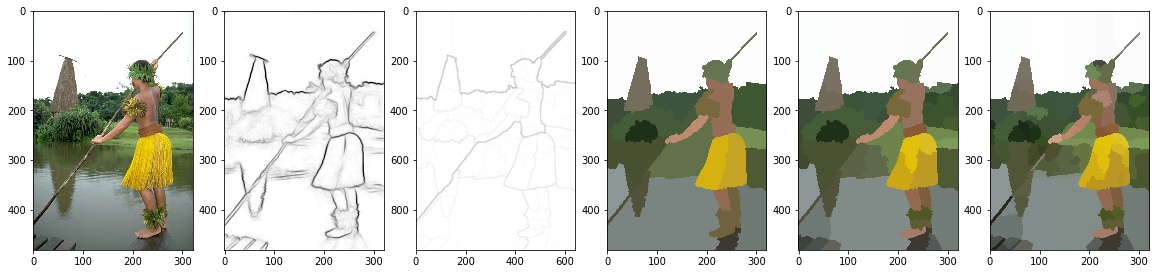

In [15]:
plt.figure(figsize=(6 * 3 + 2, 5))
image    = imageio.imread(locate_resource("101087.jpg")).astype(np.float64) / 255
gradient = imageio.imread(locate_resource("101087_SED.png")).astype(np.float64) / 255

# Edge weighted 4-adjacency graph
graph        = hg.get_4_adjacency_graph(gradient.shape[:2])
edge_weights = hg.weight_graph(graph, gradient, hg.WeightFunction.mean)

# Watershed hierarchy by area and its saliency map
tree, altitudes = hg.watershed_hierarchy_by_area(graph, edge_weights)
sm              = hg.saliency(tree, altitudes)
plt.subplot(1,6,1); plt.imshow(image)
plt.subplot(1,6,2); plt.imshow(1 - gradient, cmap="gray")
plt.subplot(1,6,3); plt.imshow(1 - hg.graph_4_adjacency_2_khalimsky(graph, sm) ** 0.5, cmap="gray",interpolation="bicubic")

# Get horizontal cuts containing different number of regions 
# and colorize them with the mean pixel values inside each region
mean_color = hg.attribute_mean_vertex_weights(tree, image)
cut_helper = hg.HorizontalCutExplorer(tree, altitudes)
for i, c in enumerate([25, 50, 100]):
    cut        = cut_helper.horizontal_cut_from_num_regions(c)
    simplified = cut.reconstruct_leaf_data(tree, mean_color)
    plt.subplot(1,6, 4 + i); plt.imshow(simplified)

# Performance comparison with Scikit-Learn

The following experience compares the performance of the agglomerative hierarchical clustering algorithms of Higra and Scikit-Learn. We generate sparse graphs of various sizes using a $k$-nearest neighbours algorithm (with $k=10$) on uniformly sampled points in $[0,1]^2$. For each generated graph, we run the single, complete, average, and Ward linkage agglomerative clustering algorithms from Higra (functions ``binary_partition_tree_X_linkage`` where ``X`` is replaced by the name of the linkage rule) and Scikit-Learn (functions ``linkage_tree`` for single, complete and average linkage rules, and ``ward_tree`` for Ward linkage) 7 times and we computed the mean and standard deviation runtime for each graph size. We can see that Higra is constantly faster than Scikit-learn by a factor comprised between 4 and 10 and the gap seems to increase as the size of the graphs increases.

Method used to create the test graphs

In [5]:
from sklearn.neighbors import kneighbors_graph
def gen_graph(size, k=10):
    """
    Create a ``k``-nn graph with ``size`` vertices
    
    :param size: Number of vertices
    :param k: Number of neighbor per vertex
    :returns: a tuple (vertex_coordinates, adjacency_matrix, graph, edge_weights)
    """
    np.random.seed(42)
    X = np.random.rand(size, 2)
    A = kneighbors_graph(X, 10, 'distance')
    sources, targets = A.nonzero()
    sel = sources < targets
    sources = sources[sel]
    targets = targets[sel]
    ew = np.asarray(A[sources, targets])
    ew = np.squeeze(ew)
    g = hg.UndirectedGraph(size)
    g.add_edges(sources, targets)
    return X, A, g, ew

List of methods to be tested

In [6]:
from functools import partial
from sklearn.cluster import ward_tree, linkage_tree

methods={
    "single_hg": lambda g, ew, X, A:hg.binary_partition_tree_single_linkage(g, ew),
    "complete_hg": lambda g, ew, X, A:hg.binary_partition_tree_complete_linkage(g, ew),
    "average_hg": lambda g, ew, X, A:hg.binary_partition_tree_average_linkage(g, ew),
    "ward_hg": lambda g, ew, X, A:hg.binary_partition_tree_ward_linkage(g, X),
    "single_sk": lambda g, ew, X, A:linkage_tree(X, A, linkage='single'),
    "complete_sk": lambda g, ew, X, A:linkage_tree(X, A, linkage='complete'),
    "average_sk": lambda g, ew, X, A:linkage_tree(X, A, linkage='average'),
    "ward_sk": lambda g, ew, X, A:ward_tree(X, A)
}

Method used to run the tests

In [7]:
full_test = False

# size of the tested graphs
if full_test:
    sizes = [5000, 7500, 10000, 25000, 50000, 75000, 100000, 250000, 500000, 750000]
else:
    sizes = [5000, 7500, 10000]
    
num_runs = 7
l = len(sizes)

# used to store timing results
result ={
    "single_hg": [np.zeros((l,num_runs)), np.zeros((l,))],
    "complete_hg": [np.zeros((l,num_runs)), np.zeros((l,))],
    "average_hg": [np.zeros((l,num_runs)), np.zeros((l,))],
    "ward_hg": [np.zeros((l,num_runs)), np.zeros((l,))],
    "single_sk": [np.zeros((l,num_runs)), np.zeros((l,))],
    "complete_sk": [np.zeros((l,num_runs)), np.zeros((l,))],
    "average_sk": [np.zeros((l,num_runs)), np.zeros((l,))],
    "ward_sk": [np.zeros((l,num_runs)), np.zeros((l,))],
}


def test(i, size, k, res):
    """
    Runs a timing test
    
    :param i: test number
    :param s: graph size
    :param k: number of neighbors in the knn graph
    :param res: where to store timing results
    """
    X, A, g, ew = gen_graph(size, k)
    nbe = g.num_edges()
    
    for m, (t, n) in tqdm(res.items(), desc=str(nbe)):
        for k in range(num_runs):
            
            t1 = time.time()
            methods[m](g, ew, X, A)
            t2 = time.time()
            
            t[i, k] = (t2 - t1)
            n[i] = nbe

Runs tests: **Warning: this may take time**

In [8]:
for i, s in enumerate(sizes):
    test(i, s, 10, result)

3749613: 100%|██████████| 8/8 [45:30<00:00, 498.50s/it]


In [9]:
def draw_timing(m, res):
    yhg = res[m + "_hg"][0] / res[m + "_hg"][1][:,None] * 1e6
    myhg = np.mean(yhg, 1)
    ysk = res[m + "_sk"][0] / res[m + "_sk"][1][:,None] * 1e6
    mysk = np.mean(ysk, 1)
    
    mm = max(np.max(yhg), np.max(ysk))
    
    plt.errorbar(res[m + "_hg"][1], myhg, np.std(yhg, 1), fmt='x')
    plt.errorbar(res[m + "_sk"][1], mysk, np.std(ysk, 1), fmt='o')
    plt.legend(["Higra", "Scikit-learn"])
    plt.xscale("log")
    plt.ylim(0.0, mm * 1.2)
    plt.title(m.capitalize() + " linkage")
    plt.ylabel("Time/edge microseconds")
    plt.xlabel("Number of edges")

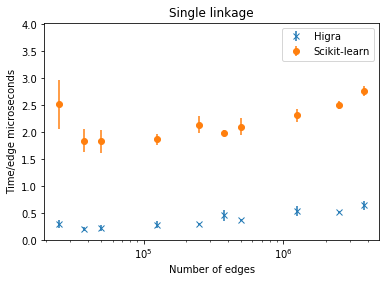

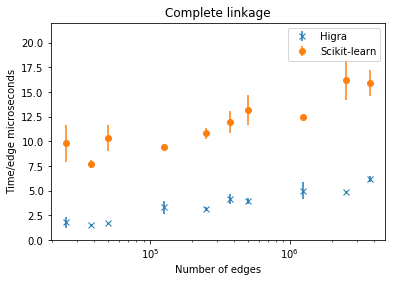

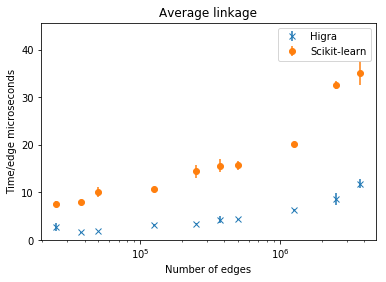

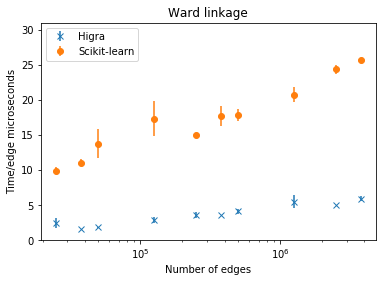

In [10]:
plt.figure(); draw_timing("single", result)
plt.figure(); draw_timing("complete", result)
plt.figure(); draw_timing("average", result)
plt.figure(); draw_timing("ward", result)